# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблями из самых популярных библиотек.

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
import os
# import catboost
from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBRegressor

ModuleNotFoundError: No module named 'catboost'

### Задание 1 (3 балла)
Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание. Используйте реализацию дерева из HW3.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [29]:
class RandomForestClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, max_features="auto", n_estimators=10):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        # raise NotImplementedError()
        self.trees = []
        self.index_t = []

    
    def fit(self, X, y):
        for i in range(self.n_estimators):
            tree_my = DecisionTreeClassifier(criterion=self.criterion, max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            indices = [random.choice(range(len(X))) for i in range(len(X))]
            
            tree_my.fit(X.iloc[indices], y.iloc[indices])
            self.trees.append(tree_my)
            self.index_t.append(indices)
    
    def predict(self, X):
        result = np.array([tree.predict(X) for tree in self.trees ])
        y_pred = np.array([np.argmax(np.bincount(column)) for column in result.T])
        return np.array(y_pred)
    
    def predict_proba(self, X):
        predicted = np.array([tree.predict(X) for tree in self.trees])
        y_pred = np.array([{1:np.mean(column), 0:1-np.mean(column)} for column in predicted.T])
        return y_pred
    
    def error(self, X, y):
        arr_error = []
        for index, row in X.iterrows():
            s_error = 0
            count = 0
            check = False
            for tree, tree_indices in zip(self.trees, self.index_t):
                if index not in tree_indices:
                    check = True
                    count += 1
                    s_error += tree.predict(X.loc[[index]])[0]
            # print(s_error, count*0.5)
            if check and (round(s_error / count) != y.at[index] ):
                # print(s_error, count, y.at[index])
                arr_error.append(1)
            else:
                # print(s_error, count)
                arr_error.append(0)
        # print(sum(arr_error) / len(X.index) , sum(arr_error), '#########',row )
        return sum(arr_error) / len(X.index) 

Ранее реализованный класс решающего дерева

In [11]:
class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        self.criterion = {'gini':gini, 'entropy':entropy}[criterion]
        self.root = None
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
    
    
    def fit(self, X, y):
        def search(self, X, y, depth):
            if len(set(y)) == 1:
                return DecisionTreeLeaf(y)
            if len(y) <= self.min_samples_leaf: 
                return DecisionTreeLeaf(y)
            if not (self.max_depth == None) and depth >= self.max_depth: 
                return DecisionTreeLeaf(y)

            gain_m = -float('Inf')
            
            is_split = False
            gain_dim = '' 
            i = -1
            val_m = 0
            for col in X.columns:
                i += 1
                dim = X[col]
                for k in set(dim):
                    left = y.loc[dim < k]
                    right = y.loc[dim >= k]
                    if len(left)*len(right) != 0:
                        cur_gain = gain(left, right, self.criterion)
                        if cur_gain > gain_m:
                            is_split = True
                            gain_m = cur_gain
                            val_m = k
                            gain_dim = col
                            gi = i
            if not is_split:
                return DecisionTreeLeaf(y)
            
            left = y.loc[X[gain_dim] < val_m]
            left_X = X.loc[X[gain_dim] < val_m]
            right = y.loc[X[gain_dim] >= val_m]
            right_X = X.loc[X[gain_dim] >= val_m]
            tree_l = search(self, left_X, left, depth + 1)
            tree_r = search(self, right_X, right, depth + 1)
        
            return DecisionTreeNode(gi, val_m, tree_l, tree_r)
        
        self.root = search(self, X, y, 0)
        

    def predict_proba(self, X):
        
        def inst(self, root, arr):
            if isinstance(root,DecisionTreeLeaf):
                a = {}
                values, counts = np.unique(root.y, return_counts=True)
                for i in range(len(values)):
                    a[values[i]] = counts[i] / len(root.y)
                return a
            else:
                if arr[root.split_dim] < root.split_value:
                    answer_1 = root.left
                else:
                    answer_1 = root.right
                return inst(self, answer_1, arr)
        
        answer = []
        for val in X.values:
            answer.append(inst(self, self.root, np.array(val)))
        return answer
    
    def predict(self, X):
        proba = self.predict_proba(X)
        full_answer = []
        for i in proba:
            ans = 0
            n_max = list(i.keys())
            n_max = n_max[0]
            for key in i.keys():
                if ans<i[key]:
                    ans = max(ans, i[key])
                    n_max = key 
            full_answer.append(n_max)
        return full_answer 

In [3]:
def gini(x):
    p = sum(x) / len(x)
    return 2 * p * (1 - p)
    
def entropy(x):
    p = sum(x) / len(x)
    return -p * log2(p) - (1 - p) * log2(1 - p)
    
def gain(left_y, right_y, criterion):
    y = np.concatenate((left_y, right_y), axis=0)
    before_split = criterion(y)
    after_split = (len(left_y) * criterion(left_y) + len(right_y) * criterion(right_y)) / len(y)
    return before_split - after_split

In [4]:
class DecisionTreeLeaf:
    def __init__(self, y):
        self.y = y

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

### Задание 3 (2 балла)
Оптимизируйте по `AUC` на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации `Random Forest`: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте `ROC` кривую (и выведите `AUC` и `accuracy`) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [10]:
def train_test_split(X, y, ratio, rando = 239):
    data_train = X.join(y)
    data_test = data_train.sample(frac=1 - ratio, random_state=rando)

    data_train.drop(labels=data_test.index, inplace=True)
    data_train.reset_index(drop=True, inplace=True)
    data_test.reset_index(drop=True, inplace=True)

    y_train = data_train['label']
    y_test = data_test['label']

    X_train = data_train[data_train.columns.difference(['label'])] 
    X_test = data_test[data_test.columns.difference(['label'])]

    return X_train, X_test, y_train, y_test

In [11]:
def optima (X, y):
    score_m = -float('Inf')
    for depth in [2, 3, 5, 7, 10]:
        for n_tree in  [5, 10, 20, 30, 50, 100]:
            ress = []
            for i in range(5):
                tree = RandomForestClassifier(criterion="gini", max_depth=depth, n_estimators=n_tree)
                X_train, X_test, y_train, y_test = train_test_split(X, y, 0.8, rando = i*10)
                tree.fit(X_train, y_train)
                y_pred = tree.predict(X_test)
                ress.append(roc_auc_score(y_test, y_pred))
                print('#',end='')
            score = np.mean(ress)
            if score > score_m:
                score_m = score
                parametrs = [depth, n_tree, tree]
    return score_m, parametrs

In [12]:
CANCER_DATA_PATH = 'hw2_data/cancer.csv'
SPAM_DATA_PATH = 'hw2_data/spam.csv'
def read_cancer_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    y = df.label
    X = df.drop(columns=['label'])
    y = y.replace({'M': 1, 'B': 0})
    X = X.rename(columns={x:str(y + 1) for x,y in zip(X.columns,range(len(X.columns)))})
    return X, y

def read_spam_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    y = df.label
    X = df.drop(columns=['label'])
    X = X.rename(columns={x:str(y + 1) for x,y in zip(X.columns,range(len(X.columns)))})
    return X, y

X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

In [13]:
# X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, 0.9)
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.3)

TypeError: train_test_split() got an unexpected keyword argument 'test_size'

In [66]:
_, parametrs = optima(X_train, y_train)


#####

Взято из дз №3

In [67]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [68]:
perfect_model = RandomForestClassifier(max_depth=parametrs[0], n_estimators=parametrs[1])
perfect_model.fit(X_train, y_train)
y_pred = perfect_model.predict(X_test)
p_pred = perfect_model.predict_proba(X_test)

AUC score: 0.9344334112149533
Accuracy score: 0.9415204678362573


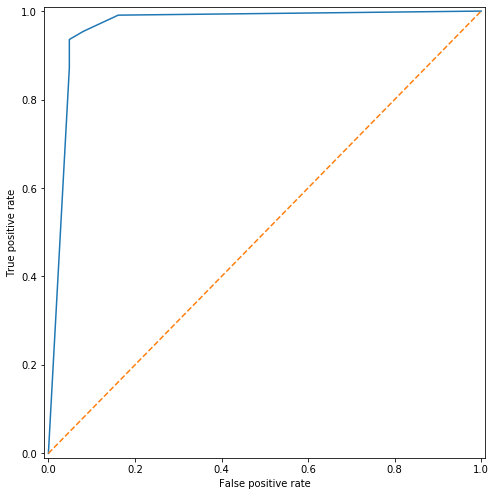

In [69]:
print(f'AUC score: {roc_auc_score(y_pred, y_test)}')
print(f'Accuracy score: {accuracy_score(y_pred, y_test)}')
plot_roc_curve(y_test, p_pred)

Лес построен не для лучшей комбинации, а для той, которую компьтер смог посчитать. (глубина 2, количество 5). Однако результат уже очень хороший!

### Задание 4 (3 балла)
Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [23]:
def feature_importance(forest, X, y):
    answer = []
    s = forest.error(X, y)
    # print(s, type(s))
    for col in X.columns:
        new = copy.deepcopy(X)
        new[col] = new[col].sample(frac=1).reset_index(drop=True)
        forest.fit(new, y)
        error = forest.error(X,y)
        answer.append(round(s - error, 5))
    return answer

def most_important_features(importance, names=[], k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return idicies
    # return np.array(names)[idicies]



Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [32]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return pd.DataFrame(X), pd.Series(y)

X, y = synthetic_dataset(20)
forest = RandomForestClassifier(n_estimators=10)
forest.fit(X, y)
print("Accuracy:", np.mean(forest.predict(X) == y))

Accuracy: 1.0


In [33]:
print("Importance:", feature_importance(forest, X, y))

Importance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Проверьте, какие признаки важны для датасетов cancer и spam?

### cancer

In [ ]:
forest = RandomForestClassifier(max_depth=5)
forest.fit(X_cancer, y_cancer)
print(*most_important_features(feature_importance(forest, X_cancer, y_cancer), k=5))

### spam

In [ ]:
forest = RandomForestClassifier(max_depth=5)
forest.fit(X_spam, y_spam)
print(*most_important_features(feature_importance(rfc, X_spam, y_spam), k=5))

_Ваш ответ_

### Задание 5 (2 балла)
В качестве альтернативы попробуем библиотечные реализации ансамблей моделей. 

1. [CatBoost](https://catboost.ai/docs/)
2. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)


Установите необходимые библиотеки. 
Возможно, потребуется установка дополнительных пакетов

In [ ]:
# !pip install lightgbm
# !pip install catboost
# !pip install xgboost

Также, как и реализованный нами RandomForest, примените модели для наших датасетов.

Для стандартного набора параметров у каждой модели нарисуйте `ROC` кривую и выведите `AUC` и `accuracy`.

Посчитайте время обучения каждой модели (можно использовать [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)). 

Сравните метрики качества и скорость обучения моделей. Какие выводы можно сделать?

По результатам проведенных сравнений можно сделать следующие выводы:
1. Все методы дают примерно одинаковый результат, что выражется в том, что показатели AUC score и Accuracy score примерно равны в сравниваемых наборах данных.
2. Можно заметить,что время работы метода catboost существенно больше времени работы lightgbm и xgboost. Однако времени работы составляет десятые доли миллисекунд, поэтому об этом можно не беспокоиться. 
3. Все эти методы работают в несколько тысяч раз быстрее, чем реализованные мною выше, так как время рассчёта превышает полчаса, а в рассмотренных ниже методах всего сотни микросекунд. 

## spam

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_spam, y_spam, test_size=0.3)

### catboost

CPU times: user 203 µs, sys: 269 µs, total: 472 µs
Wall time: 326 µs
Learning rate set to 0.5
0:	learn: 0.3312895	total: 11.1ms	remaining: 212ms
1:	learn: 0.2244778	total: 16.6ms	remaining: 149ms
2:	learn: 0.1861398	total: 22.5ms	remaining: 128ms
3:	learn: 0.1683383	total: 31.2ms	remaining: 125ms
4:	learn: 0.1566546	total: 38.3ms	remaining: 115ms
5:	learn: 0.1476228	total: 45.7ms	remaining: 107ms
6:	learn: 0.1402513	total: 52.6ms	remaining: 97.6ms
7:	learn: 0.1392778	total: 57.9ms	remaining: 86.8ms
8:	learn: 0.1325126	total: 63ms	remaining: 77ms
9:	learn: 0.1298439	total: 68.2ms	remaining: 68.2ms
10:	learn: 0.1256795	total: 73.4ms	remaining: 60.1ms
11:	learn: 0.1209748	total: 78.8ms	remaining: 52.5ms
12:	learn: 0.1204288	total: 84ms	remaining: 45.2ms
13:	learn: 0.1173847	total: 89.2ms	remaining: 38.2ms
14:	learn: 0.1110529	total: 94.8ms	remaining: 31.6ms
15:	learn: 0.1058082	total: 101ms	remaining: 25.1ms
16:	learn: 0.1035733	total: 106ms	remaining: 18.8ms
17:	learn: 0.1025200	total: 1

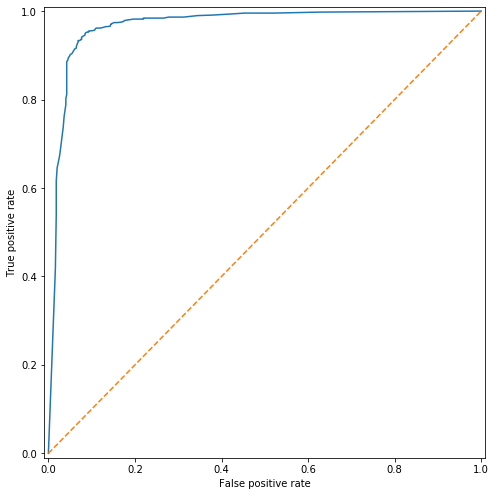

In [29]:
%time model = CatBoostClassifier(iterations=20)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions_p = model.predict_proba(X_test)
predictions_p = [{0: i[0], 1: i[1]} for i in predictions_p]
predictions = [round(x) for x in predictions]
print(f'AUC score: {roc_auc_score(predictions, y_test)}')
print(f'Accuracy score: {accuracy_score(predictions, y_test)}')
plot_roc_curve(pd.Series(y_test), predictions_p)
plt.show()

### lightgbm

CPU times: user 418 µs, sys: 160 µs, total: 578 µs
Wall time: 266 µs
AUC score: 0.9423840474280353
Accuracy score: 0.9478638667632151


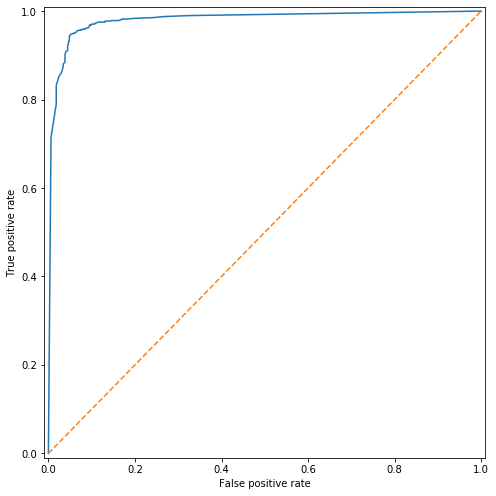

In [26]:
%time model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions_p = model.predict_proba(X_test)
predictions_p = [{0: i[0], 1: i[1]} for i in predictions_p]
predictions = [round(x) for x in predictions]
print(f'AUC score: {roc_auc_score(predictions, y_test)}')
print(f'Accuracy score: {accuracy_score(predictions, y_test)}')
plot_roc_curve(pd.Series(y_test), predictions_p)
plt.show()

### xgboost

CPU times: user 256 µs, sys: 95 µs, total: 351 µs
Wall time: 215 µs
[23:36:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


AUC score: 0.9248731522827908
Accuracy score: 0.9261404779145547


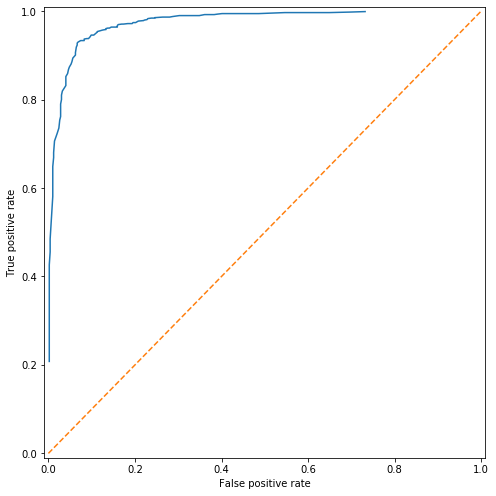

In [31]:
%time model = XGBRegressor(iterations=20)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions_p = [{1: i, 0: 1 - i} for i in predictions]
predictions = [round(x) for x in predictions]
print(f'AUC score: {roc_auc_score(predictions, y_test)}')
print(f'Accuracy score: {accuracy_score(predictions, y_test)}')
plot_roc_curve(pd.Series(y_test), predictions_p)
plt.show()

## cancer

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.3)

### catboost

CPU times: user 508 µs, sys: 827 µs, total: 1.34 ms
Wall time: 618 µs
Learning rate set to 0.251212
0:	learn: 0.4020967	total: 6.19ms	remaining: 118ms
1:	learn: 0.2511374	total: 10.9ms	remaining: 97.9ms
2:	learn: 0.1773526	total: 15.7ms	remaining: 88.7ms
3:	learn: 0.1406739	total: 20.1ms	remaining: 80.5ms
4:	learn: 0.1107711	total: 24.9ms	remaining: 74.7ms
5:	learn: 0.0902121	total: 30.5ms	remaining: 71.2ms
6:	learn: 0.0720188	total: 36ms	remaining: 66.9ms
7:	learn: 0.0597563	total: 40.8ms	remaining: 61.2ms
8:	learn: 0.0526207	total: 44.8ms	remaining: 54.7ms
9:	learn: 0.0490574	total: 48.5ms	remaining: 48.5ms
10:	learn: 0.0432093	total: 52.2ms	remaining: 42.7ms
11:	learn: 0.0381767	total: 56.3ms	remaining: 37.5ms
12:	learn: 0.0346950	total: 60ms	remaining: 32.3ms
13:	learn: 0.0316719	total: 63.6ms	remaining: 27.3ms
14:	learn: 0.0281718	total: 67.2ms	remaining: 22.4ms
15:	learn: 0.0256446	total: 70.8ms	remaining: 17.7ms
16:	learn: 0.0250685	total: 74.5ms	remaining: 13.1ms
17:	learn: 0.0

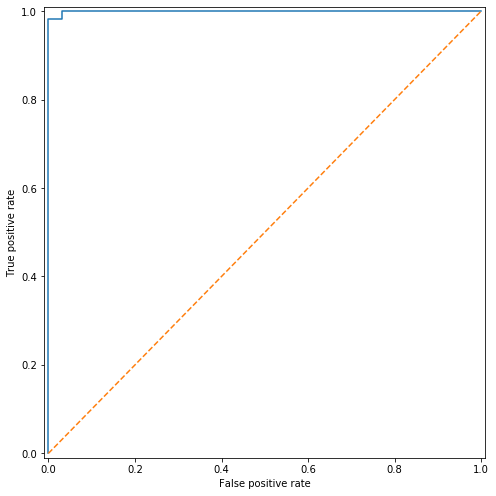

In [34]:
%time model = CatBoostClassifier(iterations=20)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions_p = model.predict_proba(X_test)
predictions_p = [{0: i[0], 1: i[1]} for i in predictions_p]
predictions = [round(x) for x in predictions]
print(f'AUC score: {roc_auc_score(predictions, y_test)}')
print(f'Accuracy score: {accuracy_score(predictions, y_test)}')
plot_roc_curve(pd.Series(y_test), predictions_p)
plt.show()

### lightgbm

CPU times: user 132 µs, sys: 1e+03 ns, total: 133 µs
Wall time: 136 µs
AUC score: 0.9846153846153847
Accuracy score: 0.9883040935672515


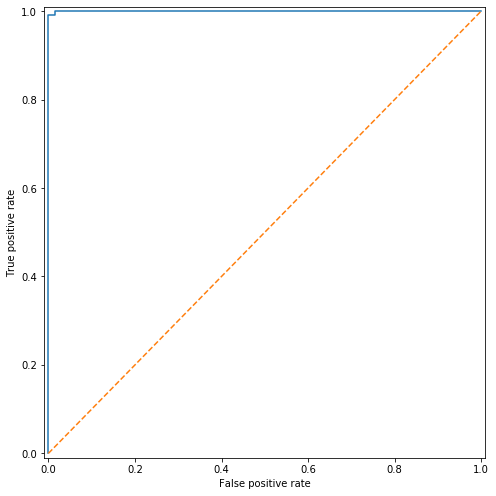

In [35]:
%time model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions_p = model.predict_proba(X_test)
predictions_p = [{0: i[0], 1: i[1]} for i in predictions_p]
predictions = [round(x) for x in predictions]
print(f'AUC score: {roc_auc_score(predictions, y_test)}')
print(f'Accuracy score: {accuracy_score(predictions, y_test)}')
plot_roc_curve(pd.Series(y_test), predictions_p)
plt.show()

### xgboost

CPU times: user 492 µs, sys: 88 µs, total: 580 µs
Wall time: 311 µs
[23:39:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC score: 0.9797021028037383
Accuracy score: 0.9824561403508771


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


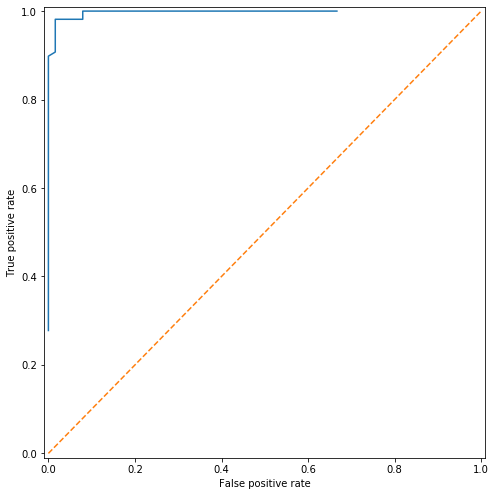

In [36]:
%time model = XGBRegressor(iterations=20)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions_p = [{1: i, 0: 1 - i} for i in predictions]
predictions = [round(x) for x in predictions]
print(f'AUC score: {roc_auc_score(predictions, y_test)}')
print(f'Accuracy score: {accuracy_score(predictions, y_test)}')
plot_roc_curve(pd.Series(y_test), predictions_p)
plt.show()